This notebook explores plotting a PPI file, mapping moments to a model-like field and plotting. We will do this by loading a radar file from MDV from ARM's C-Band system at the Southern Great Plains.

Go fetch the data from <a href = 'https://engineering.arm.gov/~collis/asr_tutorial/235545.mdv', target=newtab> HERE </a> and place it in the same directory as this notebook.  If you save the file elsewhere adjust the *data_dir* variable to point to the correct directory.

In [ ]:
# load relevant modules, set plotting to inline
import pyart
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

In [57]:
data_dir = ''
filename = 'KVNX20110520_101906_V06'
fqfn = data_dir + filename

In [58]:
radar = pyart.io.read(fqfn)

In [59]:
# Lets see what moments we have
radar.fields.keys()

['differential_phase',
 'cross_correlation_ratio',
 'spectrum_width',
 'reflectivity',
 'differential_reflectivity',
 'velocity']

Lets create a nice single PPI plot from the C-SAPR PPI scan.. Py-ART has a series of display routines in pyart.graph . First thing we do is create a display object.

In [60]:
display = pyart.graph.RadarDisplay(radar)


Now we create a Matplotlib figure object and invoke the plot_ppi method

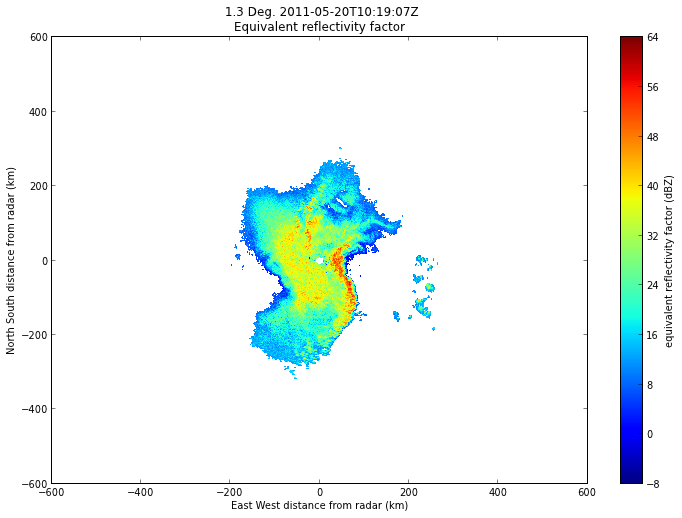

In [61]:
my_figure = plt.figure(figsize=[12, 8])
display.plot_ppi('reflectivity', 4, vmin=-8, vmax=64)

Lets zoom in! 

In [2]:
print radar.fields.keys()

NameError: name 'radar' is not defined

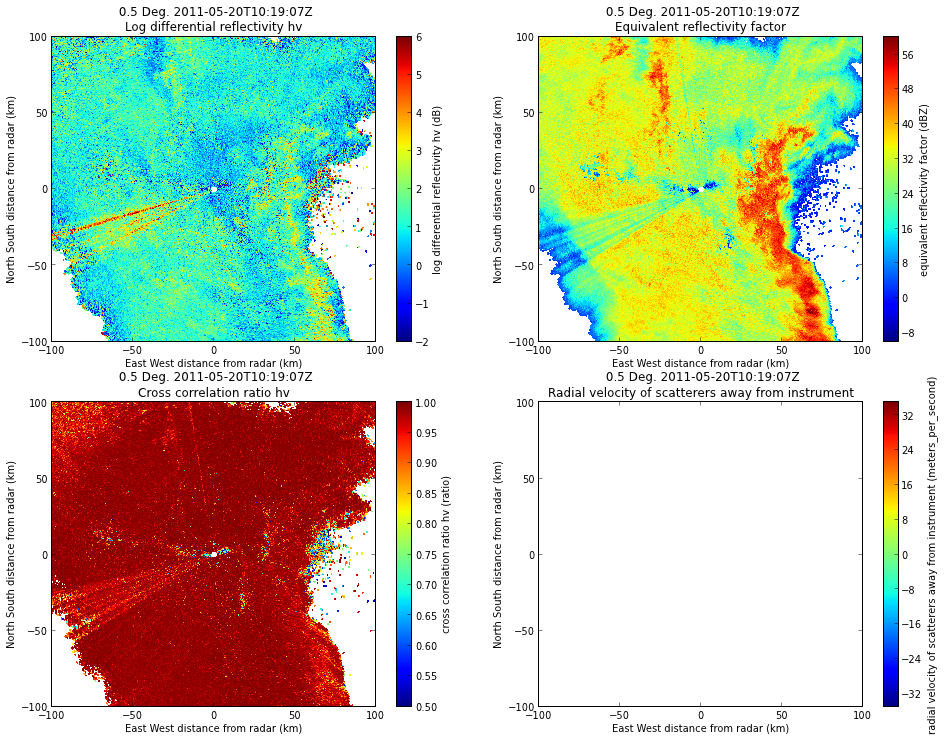

In [64]:
my_figure = plt.figure(figsize=[16, 12])
ax1=my_figure.add_subplot(221)
display.plot_ppi('differential_reflectivity', 0, vmin=-2, vmax=6)
display.set_limits(ylim=[-100, 100], xlim=[-100,100])

ax2=my_figure.add_subplot(222)
display.plot_ppi('reflectivity',0,vmin=-10,vmax=60)
display.set_limits(ylim=[-100,100],xlim=[-100,100])

ax3=my_figure.add_subplot(223)
display.plot_ppi('cross_correlation_ratio',0,vmin=0.5,vmax=1.0)
display.set_limits(ylim=[-100,100],xlim=[-100,100])

ax4=my_figure.add_subplot(224)
display.plot_ppi('velocity',0,vmin=-35,vmax=35)
display.set_limits(ylim=[-100,100],xlim=[-100,100])

Added Bonus! Lets do a Contoured Frequency By Atlitude Diagram (CFAD), this is so easy in Python! First we take our field and flatten it from a 2D array to a long 1D array.. Then we define what gates we want to use, in this case we lop off the last 20 in each ray and filter on Normalized Coherent Power must be greater that 0.5.

In [65]:
#good = np.where(radar.fields['normalized_coherent_power']['data'][:,0:-20].flatten() > .5)[0] 

#NOTE! This will only work if your radar has a NCP field.. Which Nexrad does not.. 
#Uncomment the below for NEXRAD

good = np.where(radar.fields['reflectivity']['data'][:,0:-20].flatten() > -100)[0]

Now we create our histogram! Note we are going to use the height coordinate calculated for us in my_display, this uses a 4/3 earth radius refractivity correction. 

In [66]:
H, xedges, yedges = np.histogram2d(display.z[:,0:-20].flatten()[good]/1000.0,
    radar.fields['reflectivity']['data'][:,0:-20].flatten()[good],
     bins=(62, 60), range=([0,17], [-10,64]))

Ok! Lets Plot! We create a matplotlib figure object and use the edges and histogram (H) to creat a pcolormesh plot.

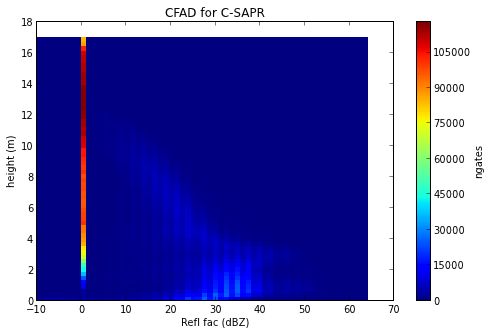

In [67]:
fig = plt.figure(figsize=[8,5])
plt.pcolormesh(yedges, xedges, H)
plt.xlabel('Refl fac (dBZ)')
plt.ylabel('height (m)')
cb=plt.colorbar()
cb.set_label('ngates')
plt.title('CFAD for C-SAPR')

Ok, obviously there is a swag of things we need to do before we map like clutter rejection, dealiasing, but we will leave this for you to learn! Take a look at the examples <a href = 'http://arm-doe.github.io/pyart/dev/auto_examples/index.html', target=newtab> Here </a>. NOTE: We are going to do a course grid, with limited levels as this is very CPU and memory intensive.. Calling is simple:
pyart.map.grid_from_radars(tuple_of_radars, grid_shape=(nz,ny,nx), 
                           grid_limits=((z1,z2), ..., (x1,x2)).. )

In [73]:
grids = pyart.map.grid_from_radars(
        (radar,),
        grid_shape=(11, 101, 101),
        grid_limits= ((0, 11000), (-200.00*1000.0, 200.*1000.0), (-200.0*1000.0, 200.*1000.0)),
        fields=['reflectivity','velocity'],
        refl_field='reflectivity',
        max_refl=100.)

Ok! Patience folks! This takes a little time.. So les see what this gives us! This is a Python Grid object

In [69]:
print grids.fields.keys()
print grids.axes.keys()

['velocity', 'reflectivity', 'ROI']
['x_disp', 'z_disp', 'time_start', 'y_disp', 'time', 'lat', 'alt', 'lon', 'time_end']


So the fields we have are Range Of Influence and reflectivity. The ROI is what was used to map the gates to the cartesian points, this is configurable but left to another tutorial! grids.axes contains all you geolocating fun.. We could plot manually but Py-ART comes with a swag of grid plotting

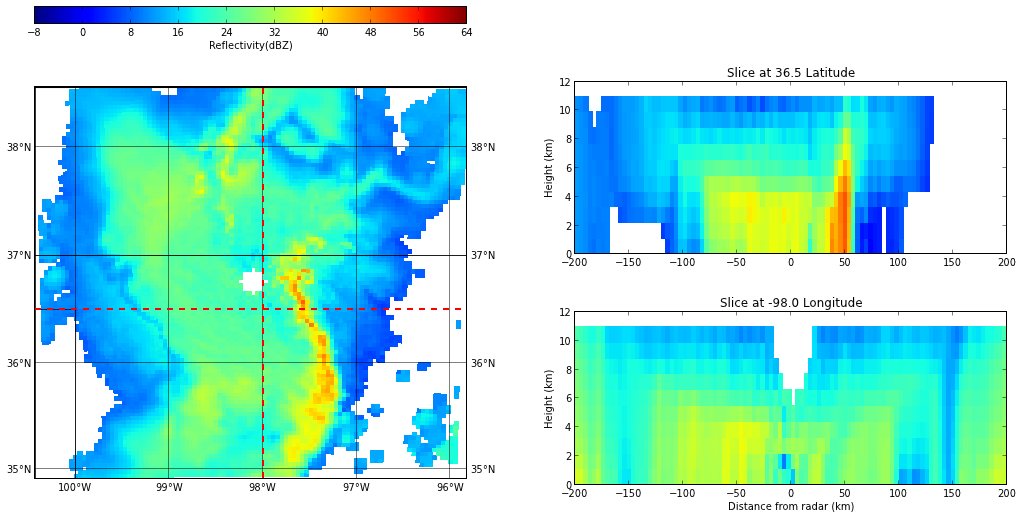

In [75]:
# panel sizes
map_panel_axes = [0.05, 0.05, .4, .80]
x_cut_panel_axes = [0.55, 0.10, .4, .30]
y_cut_panel_axes = [0.55, 0.50, .4, .30]
colorbar_panel_axes = [0.05, 0.90, .4, .03]

# parameters
level = 5
vmin = -8
vmax = 64
lat = 36.5
lon = -98.0

fig = plt.figure(figsize=[15, 8])

grid_display = pyart.graph.GridMapDisplay(grids)


# panel 1, basemap, radar reflectivity and NARR overlay
ax1 = fig.add_axes(map_panel_axes)
grid_display.plot_basemap()
grid_display.plot_grid('reflectivity', level=level, vmin=vmin, vmax=vmax)
grid_display.plot_crosshairs(lon=lon, lat=lat)

# colorbar
cbax = fig.add_axes(colorbar_panel_axes)
grid_display.plot_colorbar(cax=cbax)

# panel 2, longitude slice.
ax2 = fig.add_axes(x_cut_panel_axes)
grid_display.plot_longitude_slice('reflectivity', lon=lon, lat=lat, vmin=vmin, vmax=vmax)
ax2.set_xlabel('Distance from radar (km)')

# panel 3, latitude slice
ax3 = fig.add_axes(y_cut_panel_axes)
grid_display.plot_latitude_slice('reflectivity', lon=lon, lat=lat, vmin=vmin, vmax=vmax)

And once again, a true benefit of Py-ART is nice and easy saving!


In [ ]:
directory_to_save_to = ''
filename_to_save_to = 'my_cool_grid.nc'
pyart.io.write_grid(directory_to_save_to + filename_to_save_to, grids)

Want to see something super cool? Check out our example of using the grid object and grid display class to overplot MSLP from OpenDAP: http://arm-doe.github.io/pyart/dev/auto_examples/plotting/plot_grid_three_panel.html 

Thus concludes the Tutorial! Questions? Comments? Science Lead: <a href = 'mailto:scollis@anl.gov'> Scott Collis</a> Development lead: <a href = 'mailto:jhelmus@anl.gov'>Jonathan Helmus</a>.